### Итоговое задание по курсу аналитик данных.


Как и любой бизнес, компания «Мегафон» хочет повысить удовлетворённость своих клиентов качеством услуг. Это важная задача для удержания пользователей — как давних, так и недавно привлечённых. Ведь затраты на маркетинг и продвижение не оправдаются, если клиент уйдёт из-за низкого качества связи. Однако в реальном мире ресурсы всегда ограничены, и в единицу времени технический отдел может решить конечное количество задач. 

Чтобы делать это наиболее эффективно, важно определить, какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, и в первую очередь направить ресурсы на работу с ними. Для этого «Мегафон» провёл опрос своих клиентов, предложив им оценить уровень удовлетворённости качеством связи. По каждому клиенту, прошедшему опрос, были собраны технические показатели. 
 
 В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую. 

Подготовьте исследование для компании «Мегафон» и проанализируйте, как зависит (и зависит ли) оценка, которую ставит клиент в опросе, от технических показателей, которые были собраны.




![](https://go.skillbox.ru/media/files/share/%D0%91%D0%B5%D0%B7_%D0%BD%D0%B0%D0%B7%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_i75y0hZ.png)

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm
from matplotlib.ticker import FixedLocator
from scipy.stats import mannwhitneyu
from scipy.stats import kendalltau

from sklearn.ensemble import IsolationForest

In [149]:
df = pd.read_csv('megafon.csv', encoding='utf-8')

In [150]:
df.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


В исследуемом датафрейме основным таргетируемым показателем будет поле Q1, из значения которого нужно понять как технические характеристики влияют на него (и влияют ли вообще)?

Технические характеристики:
- Total Traffic(MB)  - использование траффика
- Downlink Throughput(Kbps) - скорость скачивания  
- Uplink Throughput(Kbps) - скорость отдачи  
- Downlink TCP Retransmission Rate(%) - процент повторной передачи пакета данных  
- Video Streaming Download Throughput(Kbps) - пропускная способность потокового видео  
- Video Streaming xKB Start Delay - задержка при запуске потокового видео  
- Web Page Download Throughput(Kbps) - Пропускная способность загрузки веб-страницы  
- Web Average TCP RTT(ms) - среднее время, которое требуется для отправки пакета данных  



In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

#### Удалим из датафрейма пустые и ошибочные значения

In [152]:
df = df[~df.Q1.isna()].copy()

In [153]:
df[~df.Q1.str.isdigit()]

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
80,81,"2, 9",NaN,567.03467,1049.72,149.62,1.29,1925.91,1263,761.13,475
238,239,"1, 3",NaN,347.03333,2177.92,152.08,2.23,5305.51,1039,2978.12,75
459,460,"1, 6",NaN,190.05419,13188.11,117.64,0.83,11146.57,746,1636.00,88
491,492,***** ** ***,NaN,479.50838,8675.19,230.06,0.33,6818.51,1562,2797.14,52
677,678,"3 - дер.Ширяево Волоколамского района, 9 - в М...",NaN,494.05844,638.49,149.04,3.06,763.87,4300,478.37,237
685,686,"10, 9",NaN,309.17551,1554.28,734.21,1.48,5547.02,1364,2237.10,124
834,835,"Чем даль ше,тем лучше.Спасибо за ваш труд.Оцен...",NaN,886.05369,1115.41,937.26,1.20,4439.31,1930,753.67,109
897,898,ОЦЕНКА-3/НЕВАЖНО/,NaN,257.97201,620.42,43.65,2.10,1771.26,1791,2086.17,201
980,981,Отвратительно,NaN,861.34490,728.55,119.85,1.15,1489.39,3102,445.06,675
1164,1165,"1, 3",NaN,376.56648,387.07,104.47,17.25,2640.24,2881,314.14,262


In [154]:
df[~df.Q1.str.isdigit()].shape

(39, 11)

In [155]:
39/3110

0.012540192926045015

Доля некорректно заполненных ответов по полю Q1 равно всего 1,2% и нет данных по полю Q2, поэтому данными этими можно принебречь

In [156]:
df = df[df.Q1.str.isdigit()].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3071 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3071 non-null   int64  
 1   Q1                                         3071 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3071 non-null   float64
 4   Downlink Throughput(Kbps)                  3071 non-null   float64
 5   Uplink Throughput(Kbps)                    3071 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3071 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3071 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3071 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3071 non-null   float64
 10  Web Average TCP RTT(ms) 

In [157]:
df.Q1 = df.Q1.astype('int64')

In [158]:
df.groupby('Q1')['user_id'].agg(['count',]).sort_values('count',ascending=False)

,count
Q1,
10,846
1,532
3,325
8,291
9,238
5,234
7,200
2,168
4,123


Отфильтруем некорректные ответы и сохраним в новый датафрейм

In [159]:
df = df[(df.Q1 <= 10) & (df.Q1 != 0)].copy()

Обозначим термины:

Total Traffic(MB) — объем трафика передачи данных
Downlink Throughput(Kbps) - средняя скорость скачивания  
Uplink Throughput(Kbps) - средняя скорость отдачи  
Downlink TCP Retransmission Rate(%) - процент повторной передачи пакета данных  
Video Streaming Download Throughput(Kbps) - пропускная способность потокового видео  
Video Streaming xKB Start Delay - задержка при запуске потокового видео  
Web Page Download Throughput(Kbps) - пропускная способность загрузки веб-страницы  
Web Average TCP RTT(ms) - среднее время, которое требуется для отправки пакета данных 

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

Определим параметры по названию колонок для построения графиков распределения

In [160]:
df.columns

Index(['user_id', 'Q1', 'Q2', 'Total Traffic(MB)', 'Downlink Throughput(Kbps)',
       'Uplink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)',
       'Video Streaming Download Throughput(Kbps)',
       'Video Streaming xKB Start Delay(ms)',
       'Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)'],
      dtype='object')

In [161]:
params = ['Total Traffic(MB)', 'Downlink Throughput(Kbps)',
       'Uplink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)',
       'Video Streaming Download Throughput(Kbps)',
       'Video Streaming xKB Start Delay(ms)',
       'Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']

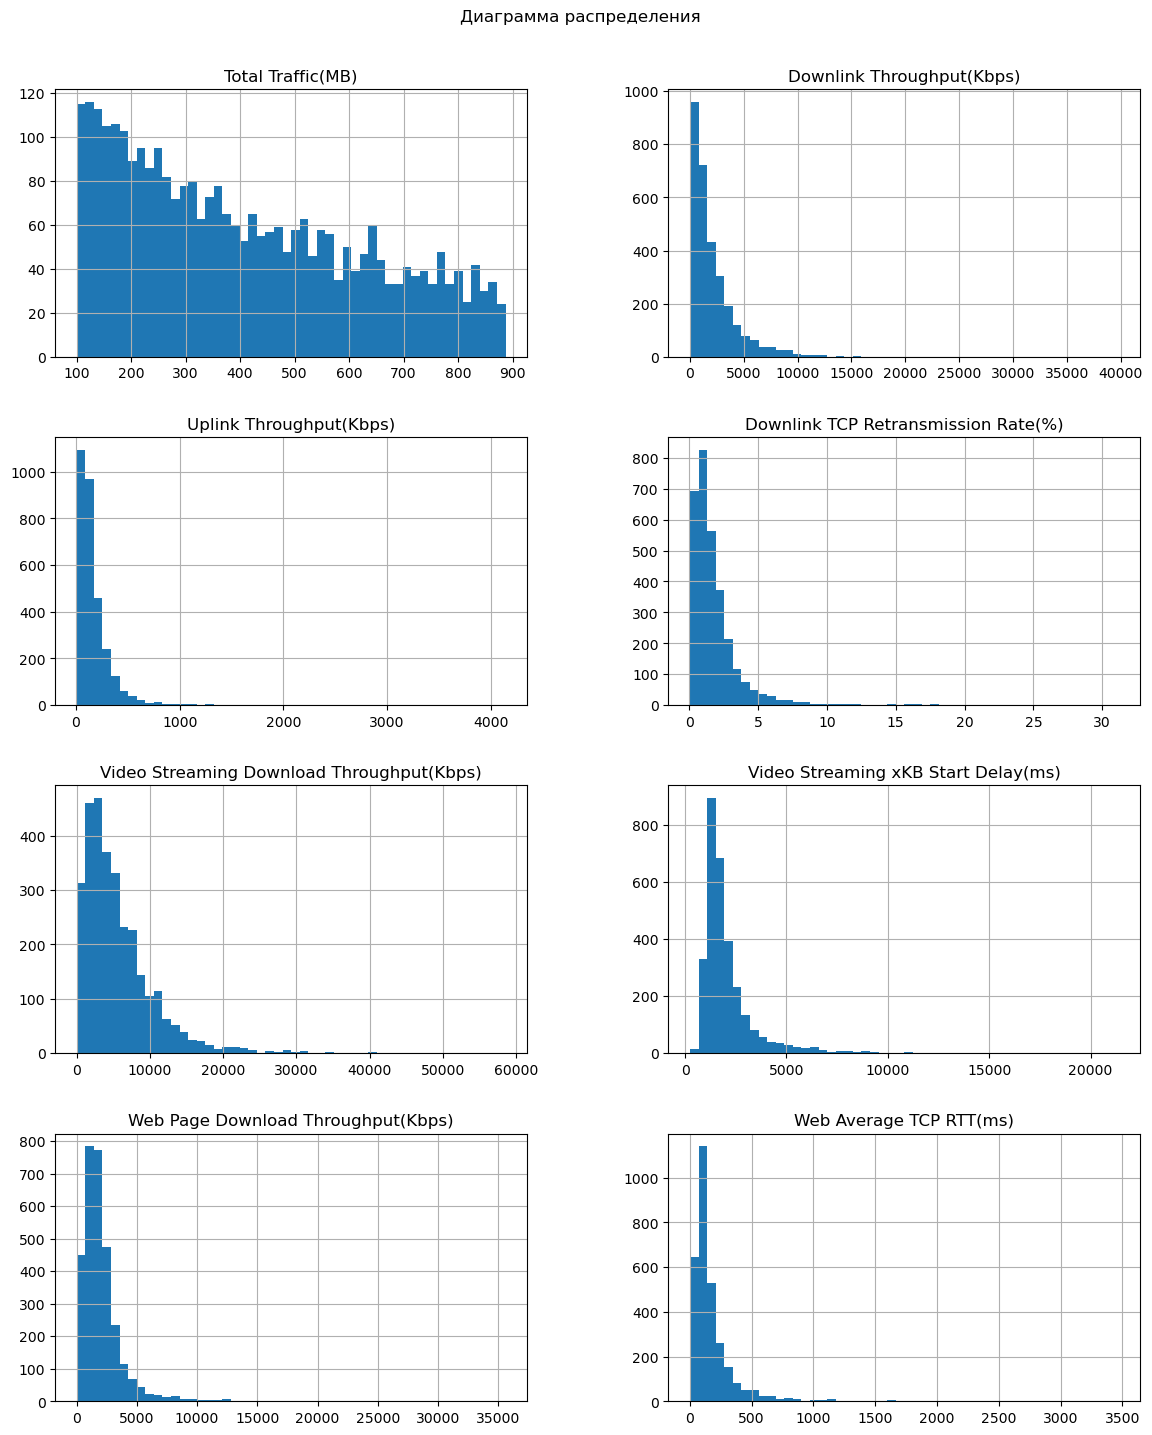

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(14, 16))
for ax, param in zip(ax.ravel(), params):
    df.hist(param, bins=50, ax=ax)
fig.suptitle('Диаграмма распределения', fontsize=12)
plt.subplots_adjust(top=0.93)
plt.show();

Как видно из диаграммы распределения ни один из параметров не распределен нормально и имеет явное смещение вправо. Можно попробовать логарифмическое преобразование чтобы получить нормальное распределение.

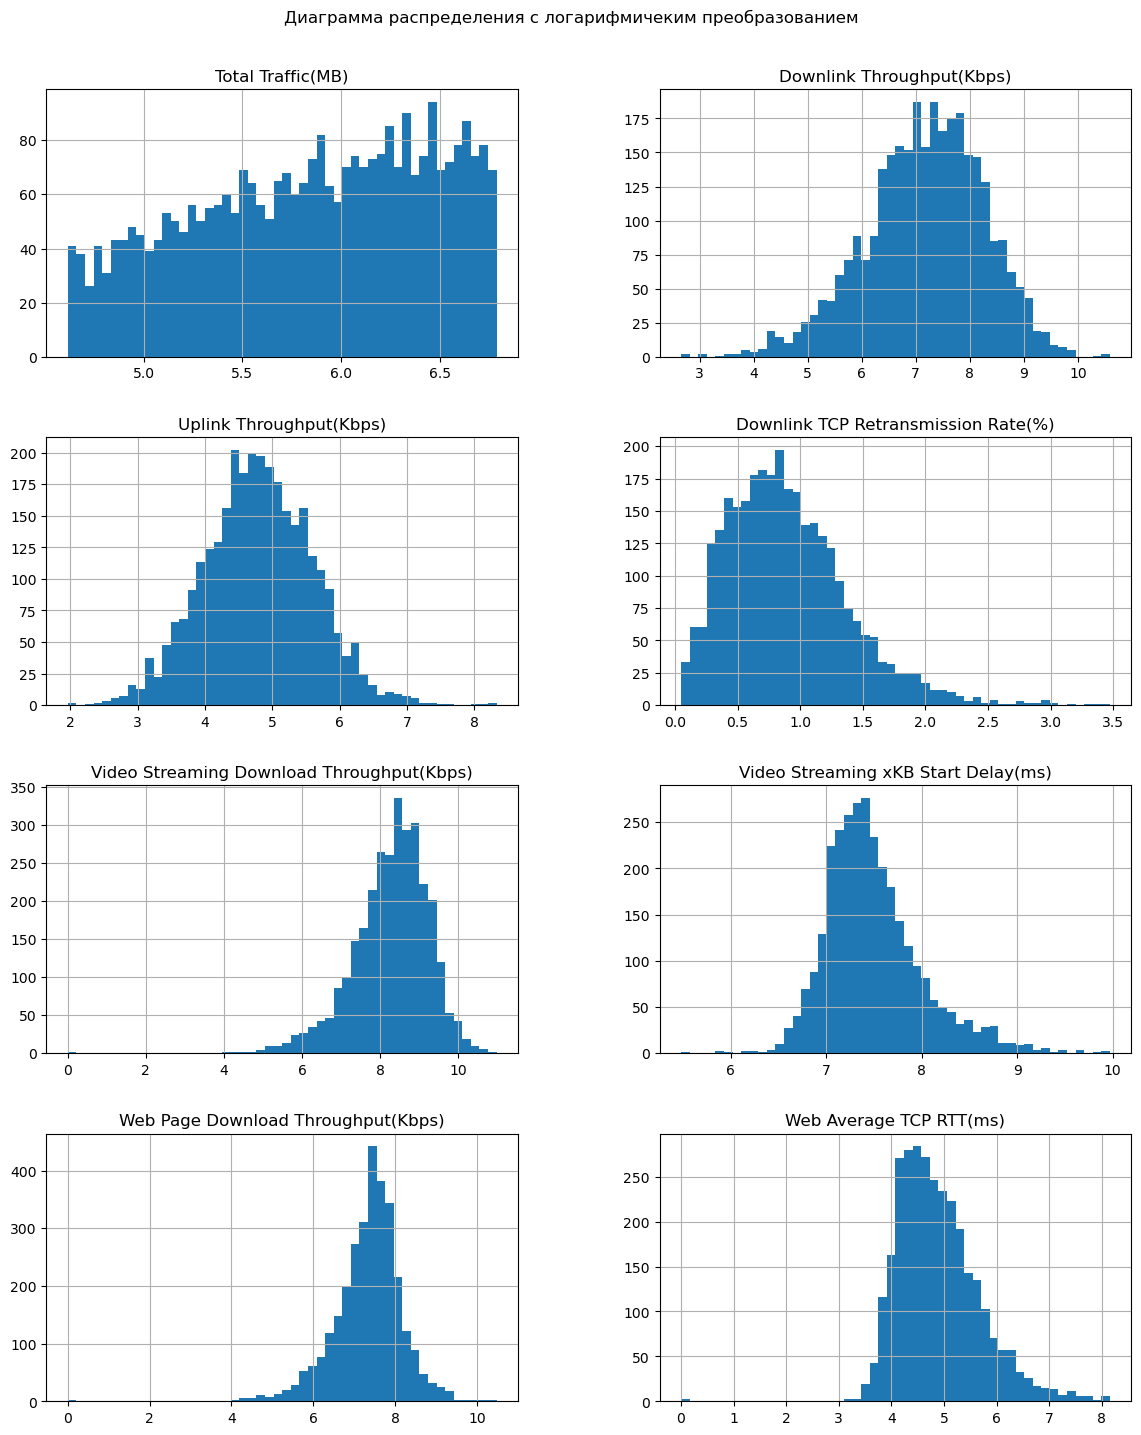

In [17]:
df_log = df[df.columns[3:]].apply(np.log1p)

fig, ax = plt.subplots(4, 2, figsize=(14, 16))
for ax, param in zip(ax.ravel(), params):
    df_log.hist(param, bins=50, ax=ax)
fig.suptitle('Диаграмма распределения с логарифмичеким преобразованием', fontsize=12)
plt.subplots_adjust(top=0.93)

Проверим на график QQplot нормальность полученных распределений

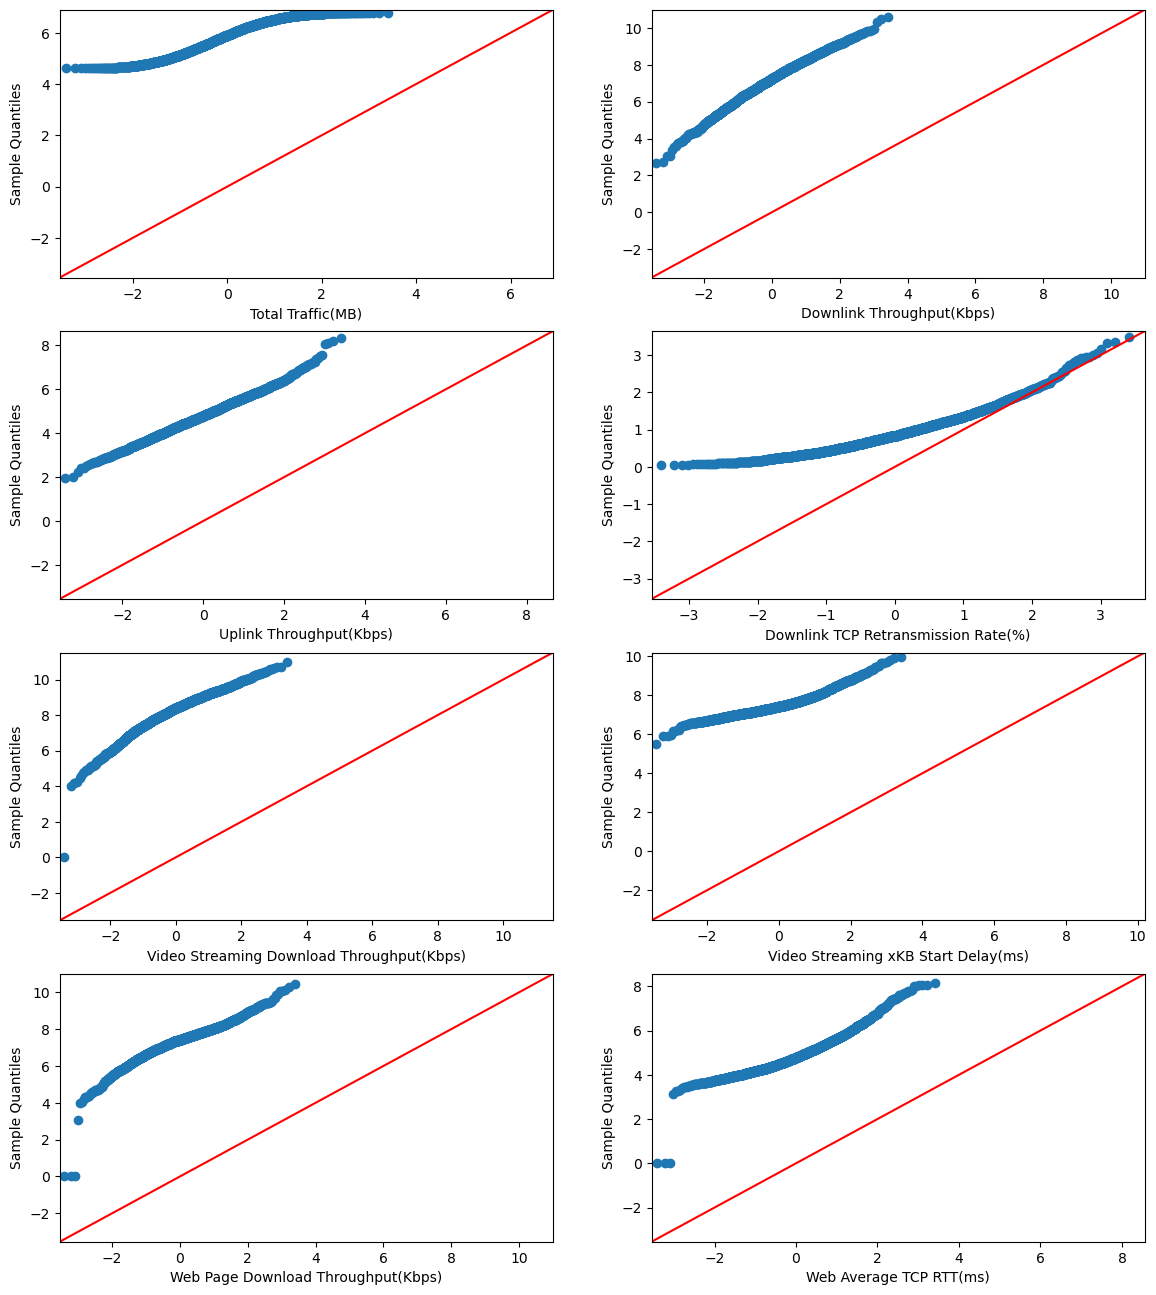

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(14, 16))
for ax, param in zip(ax.ravel(), params):
    sm.qqplot(df_log[param], ax=ax, line='45')
    ax.set_xlabel(param)
plt.show()

Из графиков видно, что не один параметр не распределён нормально, поэтому для определения корреляции лучше использовать метод Кендалла

In [19]:
df.loc[:, ~df.columns.isin(['Q2', 'user_id'])].corr(method='kendall')['Q1']

Q1                                           1.000000
Total Traffic(MB)                           -0.006440
Downlink Throughput(Kbps)                    0.090735
Uplink Throughput(Kbps)                      0.051255
Downlink TCP Retransmission Rate(%)         -0.070960
Video Streaming Download Throughput(Kbps)    0.101972
Video Streaming xKB Start Delay(ms)         -0.104996
Web Page Download Throughput(Kbps)           0.102531
Web Average TCP RTT(ms)                     -0.097094
Name: Q1, dtype: float64

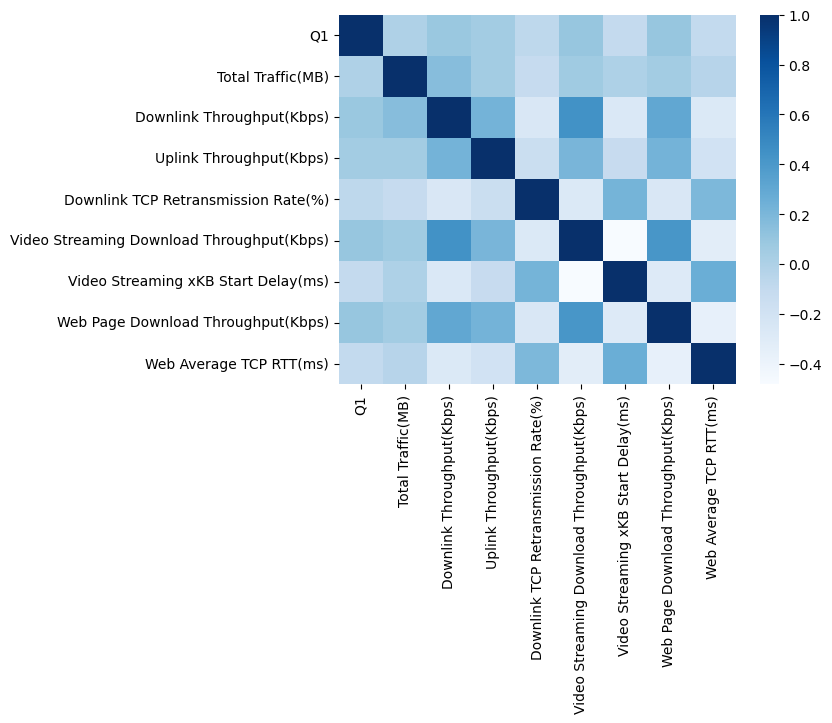

In [20]:
sns.heatmap(df.loc[:, ~df.columns.isin(['Q2', 'user_id'])].corr(method='kendall', numeric_only=True), cmap='Blues');

По значениям из таблицы полученной корреляции и графика hitmap видно, что между параметром удовледтворенности Q1 и техническими параметрами нет сильной корреляционной связи.
Из шкалы градации коэффициента корреляции Кендалла:
- 0.00-0.19: Очень слабая монотонная связь
- 0.20-0.39: Слабая монотонная связь
- 0.40-0.59: Умеренная монотонная связь
- 0.60-0.79: Заметная монотонная связь
- 0.80-1.00: Сильная монотонная связь

следует что связь очень слабая или вообще отсутсвтует 

С помощью библиотеки phik можно попробовать найти не линейную зависимость между техническими параметрами и удовлетворенностью


In [21]:
# pip install phik
import phik
from phik import report
from phik.report import plot_correlation_matrix

In [22]:
df1 = df.phik_matrix()

interval columns not set, guessing: ['user_id', 'Q1', 'Total Traffic(MB)', 'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)', 'Video Streaming Download Throughput(Kbps)', 'Video Streaming xKB Start Delay(ms)', 'Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']


In [23]:
df1['Q1'].sort_values(ascending=False)

Q1                                           1.000000
Q2                                           0.278833
Video Streaming xKB Start Delay(ms)          0.142124
Video Streaming Download Throughput(Kbps)    0.098575
Web Average TCP RTT(ms)                      0.091854
Downlink Throughput(Kbps)                    0.072913
Total Traffic(MB)                            0.069736
Web Page Download Throughput(Kbps)           0.044052
user_id                                      0.000000
Uplink Throughput(Kbps)                      0.000000
Downlink TCP Retransmission Rate(%)          0.000000
Name: Q1, dtype: float64

In [24]:
df000 = df1['Q1'].sort_values(ascending=False).reset_index()
df000 = df000.set_index('index')

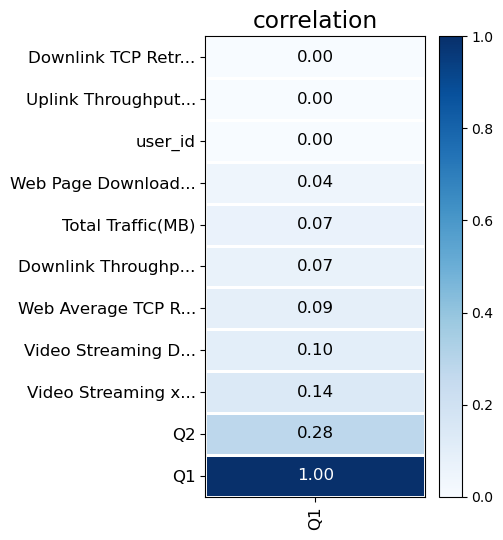

In [25]:
plot_correlation_matrix(df000.values, x_labels=df000.columns, y_labels=df000.index, 
                        vmin=0, vmax=1, color_map='Blues', fontsize_factor=1.2,
                        figsize=(5,5.5))

По результату phik корреляции среди не линейных зависимостей, можно предположить что и тут нет сильных связей между параметрами связи и удовлетворённостью клиента.

###### Далее разобъём наших респондентов на две группы по удовлетворенности качеством связи и выясним имеются ли статистически значимые различия по техническим параметрам в этих группах

In [26]:
df.groupby(pd.cut(df['Q1'], bins=[0,2,4,6,8,10]))['Q1'].count()

Q1
(0, 2]      700
(2, 4]      448
(4, 6]      335
(6, 8]      491
(8, 10]    1084
Name: Q1, dtype: int64

Сделаем разделение на группы удовлетворённости качеством связи:

- довольные - группа 1, давшие оценку 7 и выше в вопросе Q1
- недовольные - группа 2, давшие оценку 6 и ниже в вопросе Q1

в такой пропорции получились примерно равные по количество человек группы

In [162]:
df['group'] = np.where(df['Q1'] >= 7, 'group_1', 'group_2')

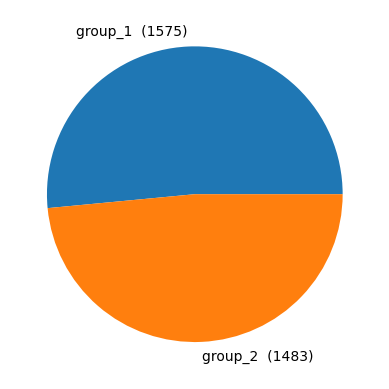

In [163]:
labels = [f'{group}  ({count})' for group, count in df.groupby(df['group'])['Q1'].count().items()]
plt.pie(df.groupby(df['group'])['Q1'].count(), labels=labels);

Группы как видно из круговой диаграммы примерно равны числу респондентов.

Так же на, построенных ранее, графиках распределения видны выбросы, поэтому перед расчётом статистик уберём эти выбросы для каждого параметра. Выбросы будем удалять с помощью ансамблеевого метода изолирванных лесов (IsolationForest) библиотеки sklearn

In [164]:
def forest_filter(df, param, Q1=None, Q2=None):
    X = df[[param,]]
    iso_forest = IsolationForest(contamination=0.2, random_state=42, n_estimators=350, bootstrap=True, n_jobs=4)
    iso_forest.fit(X)

    # Получение предсказаний модели
    df['anomaly'] = iso_forest.predict(X)
    df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 - выброс, 0 - нормальные данные
    # Фильтруем исходный набор данных
    df = df[df['anomaly']==0]

    columns_to_return = [param, 'group']
    if Q1 is not None:
        columns_to_return.append('Q1')
    if Q2 is not None:
        columns_to_return.append(Q2)
    
    return df[columns_to_return]

Так как значения технических параметров имеют не нормальное распределение, то проведём исследование средних на статистическую значимость между двумя группами методом бутстрапа. 
Напишем небольшую функция для бутстрапа:

In [165]:
def bootstrap(arr, n=100, N_TRIAL=1000, func=np.mean):
    res = []
    n = min(len(arr), n)
    # Инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # Делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size=(n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size=(n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res

для проведения анализа сформируем гипотезы:
 - H0 - нулевая гипотеза будет утверждать, что значимых различий в зависимости от параметра между нашими группами нет
 - H1 - и альтернативная гипотеза, что значимые различия между группами есть
 
Для проверки гипотез установим уровень значимости - 0,05.
Построим графики сразу для всех технических показателей и проверим наши гипотезы.

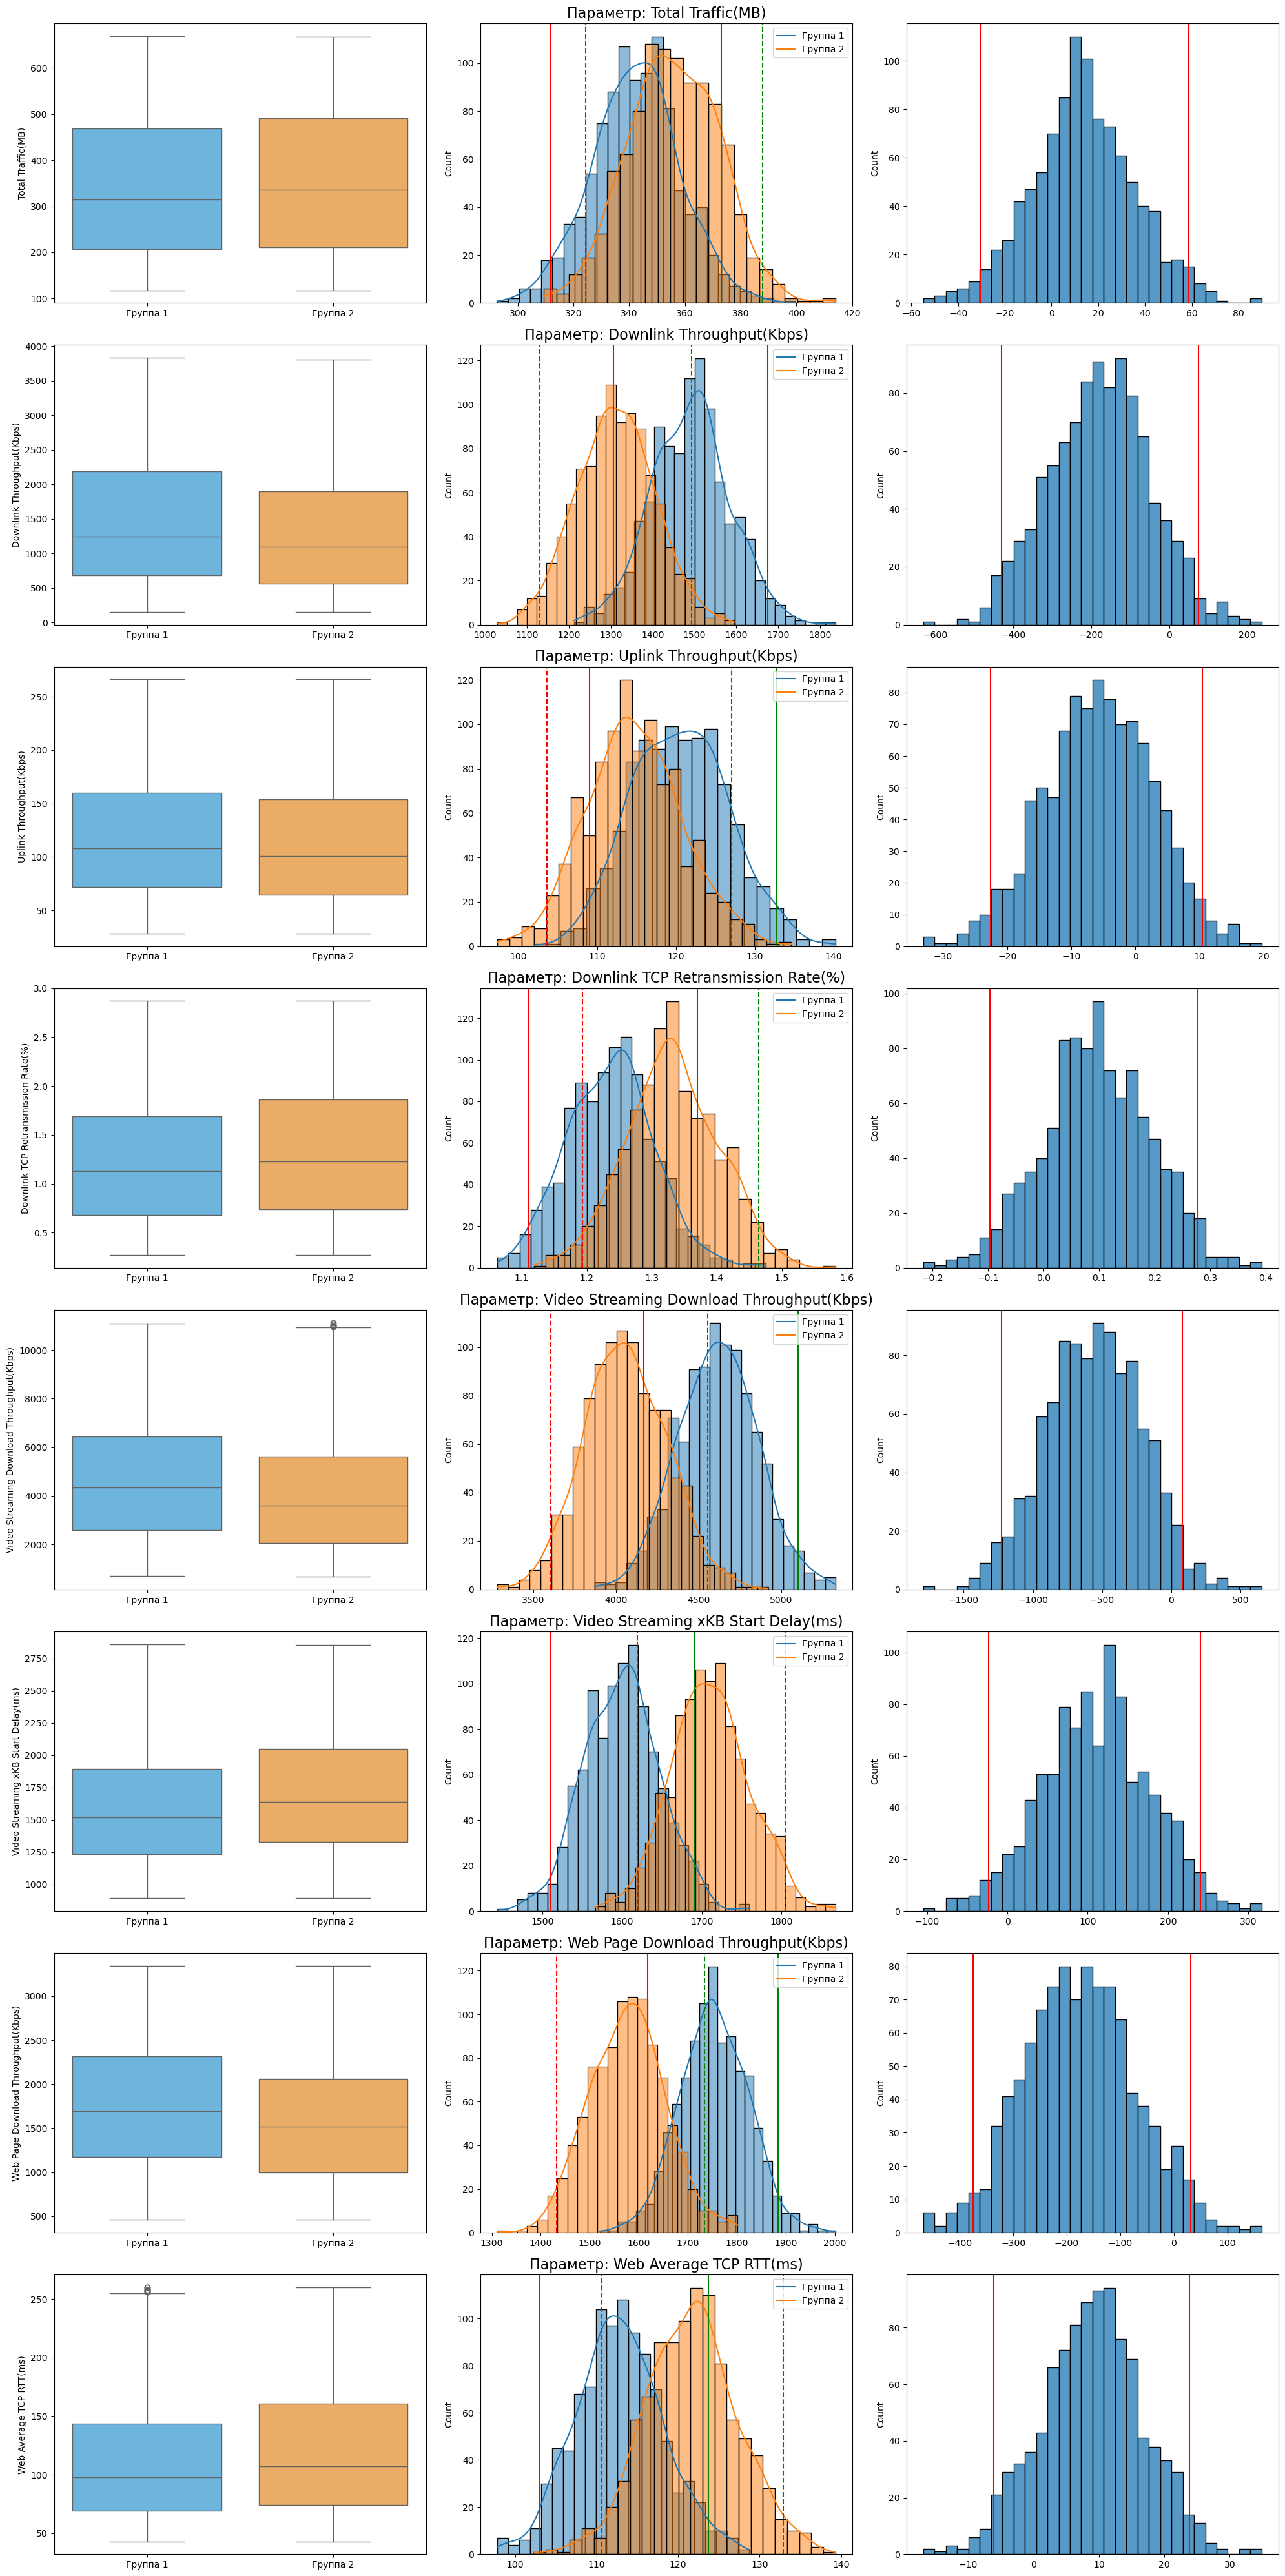

In [278]:
n_cols = 3
n_rows = 8

#уровень доверия 
confidence = 0.95

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))

# Цикл по параметрам и осям
for ax, param in zip(ax, params):
    
    # Проводим очистку выбросов по методу изолированных лесов
    df_group = forest_filter(df, param)
    df_group_1 = df_group.query('group=="group_1"')[param]
    df_group_2 = df_group.query('group=="group_2"')[param]
    
    # Создаём методом бутстрапа два набора для группы 1 и группы 2
    group_1 = bootstrap(df_group_1)
    group_2 = bootstrap(df_group_2)
    
    # Строим график boxplot для сравнения медианных значений и квантилей
    sns.boxplot(x='group', y=param, data=df_group, hue='group', orient='v', ax=ax[0], 
                order=['group_1', 'group_2'], palette={'group_1': '#5BBAEE', 'group_2': '#FFAE52'})
    ax[0].xaxis.set_major_locator(FixedLocator([0, 1]))
    ax[0].set_xticklabels(['Группа 1', 'Группа 2'])
    ax[0].set_xlabel('')
    
    # Строим два графика распределения для группы 1 и 2 для проверки пересечений доверительных интервалов
    sns.histplot(group_1, kde=True, ax=ax[1])
    sns.histplot(group_2, kde=True, ax=ax[1])
    ax[1].legend(['Группа 1','Группа 2'])
    ax[1].axvline(np.percentile(group_1, (1 - confidence) / 2 * 100), linestyle= '-',color='r')
    ax[1].axvline(np.percentile(group_1, (1 + confidence) / 2 * 100), linestyle= '-',color='g')
    ax[1].axvline(np.percentile(group_2, (1 - confidence) / 2 * 100), linestyle= '--',color='r')
    ax[1].axvline(np.percentile(group_2, (1 + confidence) / 2 * 100), linestyle= '--',color='g')
    ax[1].set_title(f"Параметр: {param}", fontsize=16)
    
    # Находим разницу средних значений двух групп
    buf = np.array(group_2) - np.array(group_1)

    # Строим график распределения разницы средних
    sns.histplot(buf, bins=30, ax=ax[2]) 
    ax[2].axvline(np.percentile(buf, (1 - confidence) / 2 * 100), linestyle='-', color='r')
    ax[2].axvline(np.percentile(buf, (1 + confidence) / 2 * 100), linestyle='-', color='r')
    

plt.tight_layout()
plt.show()

Что мы видим на графиках, слева график box plot, который показывает что медианные значения группп не выходят за пределы межквартильных значений. Исходя из этого уже можно предположить что значимых различий по техническим параметрам между группами нет. 

Но для достоверности давайте посмотрим на другие графики, распределение средних значений параметров на гистограмме, с вертикальнми линиями доверительных интервалов. На некоторых графиках может показаться, что между группами всё-таки существует значимые различия, но если обратить внимание на третий график (крайний справа), то можно увидеть что распределение разницы средних двух групп распределено вокруг 0 или же он попадает в доверетильный интервал 5%. Давайте отдельно проведём дополнительный тест Манна-Уитни (распределение не нормальное) и проверим значение pvalue, можно ли нам отвергать нулевую гипотезу.

Для проверки по тесту Манна-Уитни сформируем так же через бутстрап две группы и найдём значение pvalue для каждого параметра, так же проверим коэффициент ранговой корреляции Кендала, проверить как сильно ранги в двух группах связаны между собой.

In [300]:
for param in params:
    group_1 = bootstrap(forest_filter(df, param).query('group=="group_1"')[param])
    group_2 = bootstrap(forest_filter(df, param).query('group=="group_2"')[param])
    statistic, pvalue = mannwhitneyu(group_1, group_2, alternative='two-sided')
    tau, pvalue_tau = kendalltau(group_1, group_2)
    print(f'{param} pvalue - {pvalue}, koef tau - {tau:.4F}')
    print('-----------------------------------------------------------------------------------------------')

Total Traffic(MB) pvalue - 1.645071798689667e-57, koef tau - -0.0348
-----------------------------------------------------------------------------------------------
Downlink Throughput(Kbps) pvalue - 3.4045214946651125e-225, koef tau - -0.0225
-----------------------------------------------------------------------------------------------
Uplink Throughput(Kbps) pvalue - 4.73099549142953e-77, koef tau - -0.0196
-----------------------------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%) pvalue - 6.855265352357885e-142, koef tau - 0.0178
-----------------------------------------------------------------------------------------------
Video Streaming Download Throughput(Kbps) pvalue - 7.2299220059970284e-267, koef tau - 0.0241
-----------------------------------------------------------------------------------------------
Video Streaming xKB Start Delay(ms) pvalue - 1.8750333752309996e-254, koef tau - -0.0041
----------------------------

In [301]:
for param in params:
    group_1 = forest_filter(df, param).query('group=="group_1"')[param]
    group_2 = forest_filter(df, param).query('group=="group_2"')[param]
    statistic, pvalue = mannwhitneyu(group_1, group_2, alternative='two-sided')
#     tau, pvalue_tau = kendalltau(group_1, group_2)
    print(f'{param} pvalue - {pvalue}')
    print('-----------------------------------------------------------------------------------------------')

Total Traffic(MB) pvalue - 0.04701757966827434
-----------------------------------------------------------------------------------------------
Downlink Throughput(Kbps) pvalue - 1.5495760208027977e-06
-----------------------------------------------------------------------------------------------
Uplink Throughput(Kbps) pvalue - 0.013039183021228007
-----------------------------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%) pvalue - 0.0016498813629928766
-----------------------------------------------------------------------------------------------
Video Streaming Download Throughput(Kbps) pvalue - 2.682824891817241e-09
-----------------------------------------------------------------------------------------------
Video Streaming xKB Start Delay(ms) pvalue - 4.772295385061991e-08
-----------------------------------------------------------------------------------------------
Web Page Download Throughput(Kbps) pvalue - 6.298787247625

Можно также проверить выборки на тесте Колмогорова-Смирнова, насколько выборки разные

In [33]:
from scipy.stats import ks_2samp

In [41]:
for param in params:
    group_1 = bootstrap(forest_filter(df, param).query('group=="group_1"')[param])
    group_2 = bootstrap(forest_filter(df, param).query('group=="group_2"')[param])
    statistic, pvalue = ks_2samp(group_1, group_2)
    print(f'{param} pvalue - {pvalue}')
    print('-----------------------------------------------------------------------------------------------')

Total Traffic(MB) pvalue - 2.721684992649387e-134
-----------------------------------------------------------------------------------------------
Downlink Throughput(Kbps) pvalue - 1.9641677051229537e-174
-----------------------------------------------------------------------------------------------
Uplink Throughput(Kbps) pvalue - 1.738153036256123e-33
-----------------------------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%) pvalue - 1.126719870764413e-139
-----------------------------------------------------------------------------------------------
Video Streaming Download Throughput(Kbps) pvalue - 0.0
-----------------------------------------------------------------------------------------------
Video Streaming xKB Start Delay(ms) pvalue - 3.997226033619498e-299
-----------------------------------------------------------------------------------------------
Web Page Download Throughput(Kbps) pvalue - 0.0
---------------------

Значение pvalue по всем параметрам меньше 0,05 что позволяет нам отвергнуть нулевую гипотезу, но коэффициент тау показывает слабую корреляцию между параметрами и группой пользователей.

Возникает парадоксальная ситация, на основании статистики мы должны отвергнуть нулевую гипотезу об отсуствии статитистически значимых различий между группами удовлетворенных и не очень пользователей, с уверенностью в 95% можно сказать что разница между группами есть. В первую очередь это связано с размерами выборок, в нашем случае мы провели тест Манна-Уитни на больших выборках и это могло повлиять на значение pvalue, так как данный тест очень чувствительный и может обнаружить даже очень маленькие различия, которые на практике могут быть несущественнными.

Статистическая значимость не всегда совпадает с практической, в вашем случае, хотя pvalue очень маленькое, но разница может быть незначительной с точки зрения пользовательского опыта

#### Выводы:

Проведённый тест через бутстрап показал что мы не можем отклонить нулевую гипотезу по всем техническим параметрам, между группой 1 и 2 нет статитстически значимых различий. Необходимо провести дополнительные исследования, чтобы определить, какие другие факторы могут влиять удовлетворённость клиентов.

На следующей визуализации построим столбчатые графики со средним значением каждого технического показателя, проверим прослеживается ли какая-либо тенденция в данных в зависимости от оценки качества связи.

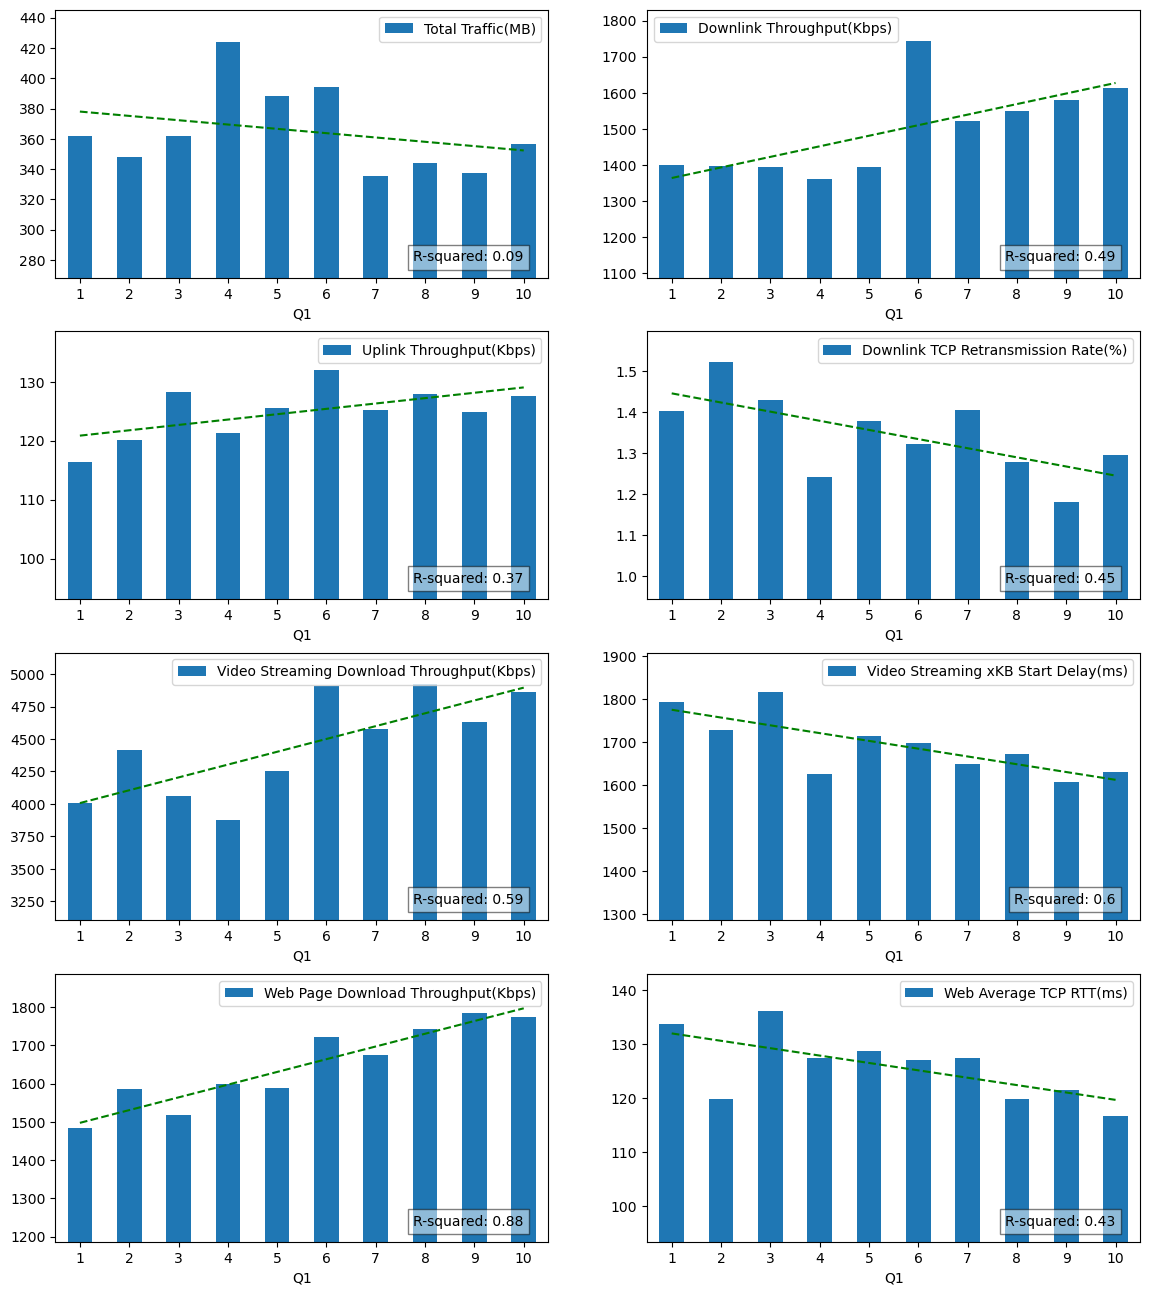

In [34]:
fig, ax = plt.subplots(4, 2, figsize=(14, 16))
for ax, param in zip(ax.ravel(), params):
    df_ = forest_filter(df, param, Q1=1).groupby(['Q1'])[param].mean().reset_index()

    df_.plot.bar(x='Q1', y=param, rot=0, legend=param, ax=ax)

    # Создание данных для линии тренда
    coefficients = np.polyfit(df_['Q1'], df_[param], 1)
    linear_trend = np.poly1d(coefficients)

    x_values = df_['Q1']
    y_trend = linear_trend(x_values)
    ax.plot(y_trend, linestyle='--', color='g', label='Trend Line')
    ax.set_ylim(df_[param].min() * 0.8)
    ax.text(0.95, 0.05, f'R-squared: {round(r2_score(df_[param], y_trend),2)}',
            ha='right', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show();

На полученных графиках линии тренда указывают что данные меняются, в большую или меньшую сторону, в зависимости от параметра. То есть чем выше скорость скачивания (Downlink Throughput(Kbps)) или отдачи (Uplink Throughput(Kbps)), тем выше оценка удовлетворенности и соответственно чем ниже задержка при запуске потокового видео (Video Streaming xKB Start Delay) или среднее время, которое требуется для отправки пакета данных (Web Average TCP RTT(ms)), тем выше оценка. Так же и коэффициент детерминации указывает на большей части графиков, что тренд неплохо согласовывается с данными. Это логично на первый взгляд. Но если построить регрессионную модель, то показатели будут обратные. Давайте построим модель на показатели - Web Page Download Throughput(Kbps), так как у него самый высокий показатель детерминации.

#### Выполним регрессионный анализ с помощью библиотеки statsmodels

In [35]:
# Определение независимых переменных
X = df['Web Page Download Throughput(Kbps)']

# Добавление константы для свободного члена
X = sm.add_constant(X)

# Определение зависимой переменной
y = df['Q1']

# Построение модели множественной регрессии
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Q1   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     21.54
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           3.61e-06
Time:                        13:44:18   Log-Likelihood:                -8127.1
No. Observations:                3058   AIC:                         1.626e+04
Df Residuals:                    3056   BIC:                         1.627e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  5.7339      0.089     64.193      0.000       5.559       5.909
Web Page Download Throughput(Kbps)     0.0001   3.05e-05      4.641      0.000    8.17e-05       0.000
==============================================================================
Omnibus:                    19602.245   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              309.917
Skew:                          -0.218   Prob(JB):                     5.04e-68
Kurtosis:                       1.503   Cond. No.                     4.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Результаты регрессии говорят о статистической значимости Web Page Download Throughput(Kbps) и Q1 (P<0.05), но коэффициент детерминации R-squared очень мал (R-squared:	0.007), данная модель плохо соответствует данным. 
Что также говорит о том что параметр Web Page Download Throughput(Kbps) имеет не нормальное распределение (что мы видели и на графиках).

#### В дополнении к анализу технических параметров, можно провести анализ неудовлетворённости клиентов, ответивших на вопрос Q2.
Отфильтруем всех записи, где не пустые значения в поле Q2 и посмотрим на примере частотного анализа какие самые часто встречающиеся ответы.

In [39]:
df['Q2'] = df['Q2'].fillna('')
dummies = df['Q2'].str.get_dummies(sep=', ')
df = pd.concat([df, dummies], axis=1)

# удалим некорректные ответы
df = df.drop(['0', '10', '27', '34', '7', '05'], axis=1)

In [40]:
# Сгруппируем по сумме ответы из поля Q2 и отсортируем по самым популярным ответам
df.melt(value_vars=['1', '2','3','4','5','6'],var_name='Q2_value', value_name='count')\
        .groupby('Q2_value').sum()\
        .sort_values('count',ascending=False)\
        .assign(percentage=lambda x: round(x['count'] / x['count'].sum() * 100, 2))
        

,count,percentage
Q2_value,,
3,705,29.44
1,647,27.01
4,625,26.10
5,221,9.23
2,184,7.68
6,13,0.54


Из частотного анализа всех ответов на вопрос Q2 видно что больше всего не устраивает опрашиваемых:
 - 3-ий (плохое качество связи в зданиях моллах и прочее - 29%); 
 - 1 (не дозвоны обрывы при звонках - 27%); 
 - 4 (медленный мобильный интернет - 26%).
 
 
 на эти варианты ответов приходится большая часть (82% ответов) из всех возможных.

### Выводы:

Анализ данных исследования удовлетворенности клиентов качеством связи не выявил прямой зависимости между оценками клиентов и выбранными техническими параметрами сети. Корреляционный анализ показал крайне слабую связь, что может указывать на два возможных сценария: либо выбранные параметры не являются ключевыми факторами, влияющими на удовлетворенность, либо требуется дополнительная информация для более глубокого анализа, например, тип устройства, регион и тарифный план клиента.

Статистические тесты по критерию Манна-Уитни показали что между группами существует значимая разница, но данный тест очень чувствителен и может обнаружить очень малые различия, которые на практике могут быть незначительными.


Анализ отзывов клиентов с оценками ниже 9 баллов выявил, что основными причинами недовольства являются проблемы с мобильной связью (29%), недовозвоны (27%) и низкая скорость интернета (26%).

Исходя из полученных результатов, рекомендуется:

 - Пересмотреть выбор технических параметров для анализа в будущих исследованиях, возможно, включив показатели, более точно отражающие опыт клиентов (например, количество обрывов связи, скорость загрузки/выгрузки данных в различных условиях).

 - Собрать дополнительные данные о клиентах и их устройствах для проведения более детальной сегментации и выявления специфических проблемных зон.

 - Уделить особое внимание улучшению качества мобильной связи и повышению скорости интернета, так как эти аспекты являются основными источниками неудовлетворенности клиентов

In [48]:
df[df['group']=='group_2'][params + ['1', '2', '3', '4', '5', '6']].corr()[['1','2','3','4','5','6']].loc[params,:]

,1,2,3,4,5,6
Total Traffic(MB),-0.039694,-0.029478,-0.021170,0.011811,0.014795,-0.049874
Downlink Throughput(Kbps),0.036000,-0.031186,-0.026794,-0.079104,-0.084231,0.030645
Uplink Throughput(Kbps),0.024633,0.009176,-0.034404,-0.048090,-0.051020,-0.008124
Downlink TCP Retransmission Rate(%),-0.002397,0.022152,0.010403,0.048657,0.061913,-0.006149
Video Streaming Download Throughput(Kbps),0.043044,-0.003869,-0.025651,-0.140462,-0.106531,0.022113
Video Streaming xKB Start Delay(ms),0.048155,-0.015492,0.021583,0.124547,0.017543,0.011477
Web Page Download Throughput(Kbps),0.054548,-0.033960,-0.001191,-0.048775,-0.080797,0.001528
Web Average TCP RTT(ms),-0.015965,0.029671,-0.000762,0.110679,0.074485,-0.015110


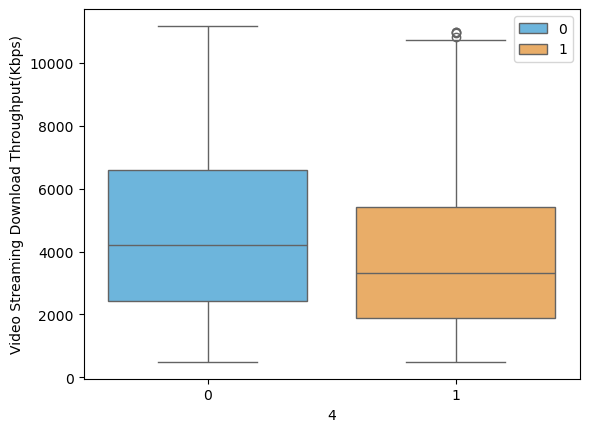

In [42]:
par_ = 'Video Streaming Download Throughput(Kbps)'
sns.boxplot(x=df['4'], y=par_, hue=df['4'], data=forest_filter(df, param=par_), palette={0: '#5BBAEE', 1: '#FFAE52'})
plt.legend();

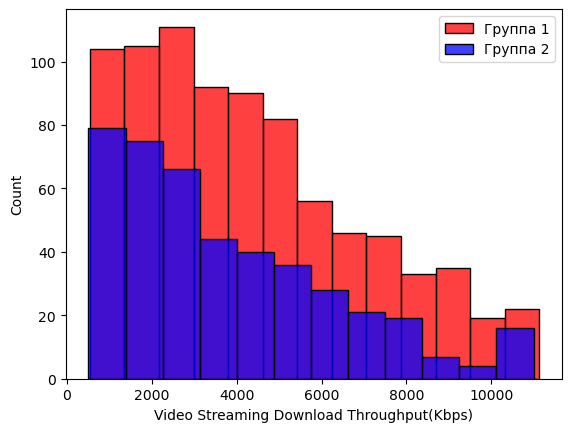

In [43]:
df_1 = forest_filter(df, param=par_, Q2='4')
sns.histplot(df_1[(df_1['group']=='group_2') & (df_1['4']==0)][par_], color='red', label='Группа 1')
sns.histplot(df_1[(df_1['group']=='group_2') & (df_1['4']==1)][par_], color='blue', label='Группа 2')
plt.legend();

In [44]:
gr_1 = bootstrap(df_1[(df_1['group']=='group_2') & (df_1['4']==1)]['Video Streaming Download Throughput(Kbps)'])
gr_2 = bootstrap(df_1[(df_1['group']=='group_2') & (df_1['4']==0)]['Video Streaming Download Throughput(Kbps)'])

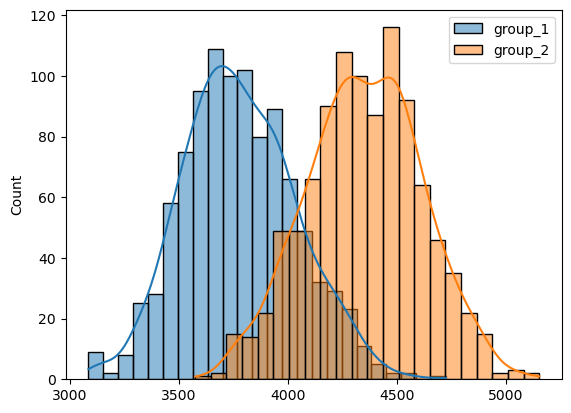

In [45]:
sns.histplot(gr_1, label='group_1', kde=True, )
sns.histplot(gr_2, label='group_2', kde=True,)
plt.legend();

In [46]:
stat, pvalue = mannwhitneyu(gr_1, gr_2, alternative='two-sided')
pvalue

2.910862754468841e-252